# South African COVID-19 Vulnerability Map:

The 2011 census gives us valuable information for determining who might be most vulnerable to COVID-19 in South Africa. However, the data is nearly 10 years old, and we expect that some key indicators will have changed in that time. Building an up-to-date map showing where the most vulnerable are located will be a key step in responding to the disease. A mapping effort like this requires bringing together many different inputs and tools. For this competition, we’re starting small. Can we infer important risk factors from more readily available data?

The task is to predict the percentage of households that fall into a particularly vulnerable bracket - large households who must leave their homes to fetch water - using 2011 South African census data. Solving this challenge will show that with machine learning it is possible to use easy-to-measure stats to identify areas most at risk even in years when census data is not collected.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
train = pd.read_csv('./raw_data/Train.csv')
test = pd.read_csv('./raw_data/Test.csv')
sub = pd.read_csv('./raw_data/samplesubmission.csv')

In [3]:
train.head()

,ward,total_households,total_individuals,target_pct_vunerable,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
0,9D9BEUB,13569.97801,39024.03083,1.739801,0.354806,0.004781,0.170498,0.007861,0.006796,0.023082,...,0.001723,0.027796,0,0.026727,0.524666,0.041460,0.394550,0.029031,0.010292,0.599259
1,RERH3XM,13593.88256,32879.94646,1.993381,0.262140,0.002066,0.077669,0.000597,0.000977,0.003759,...,0.041982,0.021312,0,0.015754,0.993900,0.001829,0.000854,0.000586,0.002832,0.699136
2,GJWA3BO,2698.30050,8261.71093,0.038340,0.728101,0.002292,0.051663,0.008209,0.001444,0.005089,...,0.014786,0.005827,0,0.049384,0.990007,0.003582,0.002546,0.003201,0.000663,0.972315
3,GW6VRB7,1965.96698,9069.77694,7.411006,0.613206,0.138127,0.004999,0.002704,0.000000,0.002788,...,0.003087,0.003136,0,0.013562,0.928682,0.004464,0.009854,0.054701,0.002299,0.735333
4,CN9JZJC,1852.07821,9908.84404,8.223907,0.797462,0.120830,0.060677,0.001155,0.001042,0.000508,...,0.000117,0.001471,0,0.000000,0.994072,0.000476,0.004033,0.000704,0.000714,0.646964


In [4]:
def check_missing_data(data: pd.DataFrame) -> pd.DataFrame:
  """Checks a given dataframe for missing values and
  types of the data features.
  """
  total = data.isnull().sum()
  percent = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  types = []
  for col in data.columns:
      dtype = str(data[col].dtype)
      types.append(dtype)
  tt['Types'] = types
  return(np.transpose(tt))

check_missing_data(train)

,ward,total_households,total_individuals,target_pct_vunerable,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64


In [5]:
train.shape, test.shape

((3174, 50), (1102, 49))

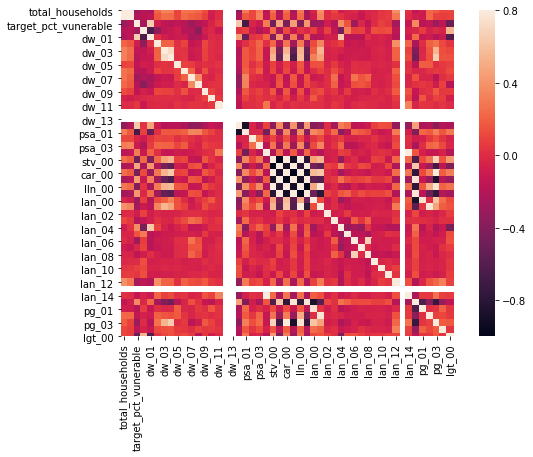

In [6]:
corr = train.corr()
fig = plt.figure(figsize = (9, 6))

sns.heatmap(corr, vmax = .8, square = True)
plt.show()

Text(0.5, 1.0, 'correlation bar_hist')

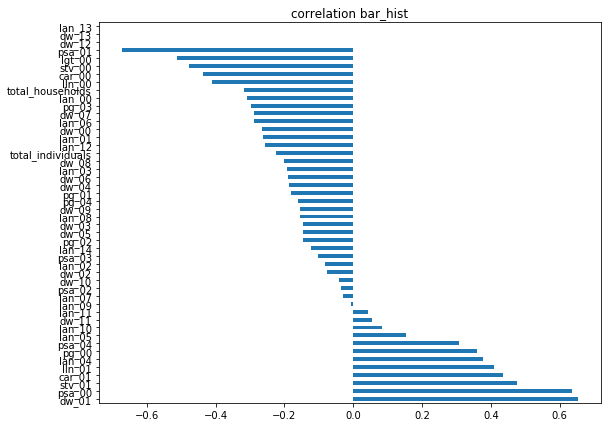

In [7]:
(corr
     .target_pct_vunerable
     .drop("target_pct_vunerable") # can't compare the variable under study to itself
     .sort_values(ascending=False)
     .plot
     .barh(figsize=(9,7)))
plt.title("correlation bar_hist")

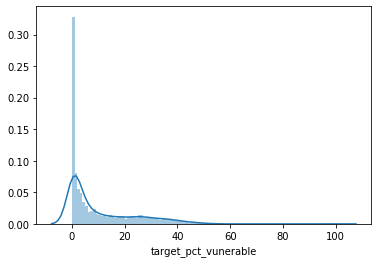

In [8]:
sns.distplot(train.target_pct_vunerable, bins=100)

In [9]:
def rmse(y,x):
    return np.sqrt(mean_squared_error(x,y))


In [12]:
drop_cols = ['target_pct_vunerable', 'ward']

y = train.target_pct_vunerable
X = train.drop(drop_cols, axis=1)
#X = StandardScaler().fit_transform(X)

ids = test['ward']
test = test.drop(drop_cols[1:], axis=1)
#tt = test[use_cols]

In [10]:
train.columns.tolist()

['ward',
 'total_households',
 'total_individuals',
 'target_pct_vunerable',
 'dw_00',
 'dw_01',
 'dw_02',
 'dw_03',
 'dw_04',
 'dw_05',
 'dw_06',
 'dw_07',
 'dw_08',
 'dw_09',
 'dw_10',
 'dw_11',
 'dw_12',
 'dw_13',
 'psa_00',
 'psa_01',
 'psa_02',
 'psa_03',
 'psa_04',
 'stv_00',
 'stv_01',
 'car_00',
 'car_01',
 'lln_00',
 'lln_01',
 'lan_00',
 'lan_01',
 'lan_02',
 'lan_03',
 'lan_04',
 'lan_05',
 'lan_06',
 'lan_07',
 'lan_08',
 'lan_09',
 'lan_10',
 'lan_11',
 'lan_12',
 'lan_13',
 'lan_14',
 'pg_00',
 'pg_01',
 'pg_02',
 'pg_03',
 'pg_04',
 'lgt_00']

In [19]:
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 50, 
    'objective': 'regression',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_val, label=y_val)

lgb_model = lgbm.train(lgb_params, train_data, valid_sets=[train_data, test_data],
                       num_boost_round=9000, early_stopping_rounds=500
                      ) #0.03lr

#lgb_df = lgbm.Dataset(X, y)
#lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=5000)

[1]	training's rmse: 12.6083	valid_1's rmse: 12.3668
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 12.3223	valid_1's rmse: 12.1281
[3]	training's rmse: 12.0502	valid_1's rmse: 11.8894
[4]	training's rmse: 11.7873	valid_1's rmse: 11.6606
[5]	training's rmse: 11.5295	valid_1's rmse: 11.4496
[6]	training's rmse: 11.2797	valid_1's rmse: 11.2284
[7]	training's rmse: 11.0339	valid_1's rmse: 11.0312
[8]	training's rmse: 10.8002	valid_1's rmse: 10.8404
[9]	training's rmse: 10.5765	valid_1's rmse: 10.6461
[10]	training's rmse: 10.357	valid_1's rmse: 10.4725
[11]	training's rmse: 10.1405	valid_1's rmse: 10.3078
[12]	training's rmse: 9.93333	valid_1's rmse: 10.14
[13]	training's rmse: 9.73649	valid_1's rmse: 9.98127
[14]	training's rmse: 9.54576	valid_1's rmse: 9.82017
[15]	training's rmse: 9.36051	valid_1's rmse: 9.67144
[16]	training's rmse: 9.18151	valid_1's rmse: 9.53574
[17]	training's rmse: 9.01143	valid_1's rmse: 9.41215
[18]	training's rmse: 8.84486	va

[158]	training's rmse: 3.58017	valid_1's rmse: 6.56361
[159]	training's rmse: 3.57685	valid_1's rmse: 6.56229
[160]	training's rmse: 3.56704	valid_1's rmse: 6.55996
[161]	training's rmse: 3.56161	valid_1's rmse: 6.56348
[162]	training's rmse: 3.55636	valid_1's rmse: 6.56485
[163]	training's rmse: 3.55362	valid_1's rmse: 6.56291
[164]	training's rmse: 3.54832	valid_1's rmse: 6.56519
[165]	training's rmse: 3.54548	valid_1's rmse: 6.56529
[166]	training's rmse: 3.53676	valid_1's rmse: 6.56522
[167]	training's rmse: 3.53284	valid_1's rmse: 6.56587
[168]	training's rmse: 3.52645	valid_1's rmse: 6.56159
[169]	training's rmse: 3.52181	valid_1's rmse: 6.56072
[170]	training's rmse: 3.51455	valid_1's rmse: 6.55929
[171]	training's rmse: 3.51107	valid_1's rmse: 6.55835
[172]	training's rmse: 3.50673	valid_1's rmse: 6.55565
[173]	training's rmse: 3.50167	valid_1's rmse: 6.55543
[174]	training's rmse: 3.49699	valid_1's rmse: 6.55244
[175]	training's rmse: 3.49259	valid_1's rmse: 6.55053
[176]	trai

[319]	training's rmse: 2.68188	valid_1's rmse: 6.47999
[320]	training's rmse: 2.67905	valid_1's rmse: 6.47874
[321]	training's rmse: 2.67185	valid_1's rmse: 6.47746
[322]	training's rmse: 2.6668	valid_1's rmse: 6.4774
[323]	training's rmse: 2.66477	valid_1's rmse: 6.47775
[324]	training's rmse: 2.66115	valid_1's rmse: 6.4765
[325]	training's rmse: 2.65883	valid_1's rmse: 6.47797
[326]	training's rmse: 2.65234	valid_1's rmse: 6.47729
[327]	training's rmse: 2.65111	valid_1's rmse: 6.47704
[328]	training's rmse: 2.6456	valid_1's rmse: 6.47789
[329]	training's rmse: 2.64314	valid_1's rmse: 6.47869
[330]	training's rmse: 2.64076	valid_1's rmse: 6.47871
[331]	training's rmse: 2.63968	valid_1's rmse: 6.47862
[332]	training's rmse: 2.6325	valid_1's rmse: 6.48067
[333]	training's rmse: 2.62361	valid_1's rmse: 6.48182
[334]	training's rmse: 2.62054	valid_1's rmse: 6.48288
[335]	training's rmse: 2.61854	valid_1's rmse: 6.48319
[336]	training's rmse: 2.61575	valid_1's rmse: 6.48227
[337]	training'

[472]	training's rmse: 2.0981	valid_1's rmse: 6.44815
[473]	training's rmse: 2.09419	valid_1's rmse: 6.44725
[474]	training's rmse: 2.08975	valid_1's rmse: 6.44757
[475]	training's rmse: 2.08891	valid_1's rmse: 6.44751
[476]	training's rmse: 2.08234	valid_1's rmse: 6.44596
[477]	training's rmse: 2.08011	valid_1's rmse: 6.44577
[478]	training's rmse: 2.07453	valid_1's rmse: 6.44521
[479]	training's rmse: 2.07103	valid_1's rmse: 6.44449
[480]	training's rmse: 2.06887	valid_1's rmse: 6.44437
[481]	training's rmse: 2.06386	valid_1's rmse: 6.443
[482]	training's rmse: 2.0601	valid_1's rmse: 6.44191
[483]	training's rmse: 2.05713	valid_1's rmse: 6.44227
[484]	training's rmse: 2.05378	valid_1's rmse: 6.44206
[485]	training's rmse: 2.05258	valid_1's rmse: 6.44178
[486]	training's rmse: 2.04983	valid_1's rmse: 6.44147
[487]	training's rmse: 2.04686	valid_1's rmse: 6.44153
[488]	training's rmse: 2.04562	valid_1's rmse: 6.4413
[489]	training's rmse: 2.04207	valid_1's rmse: 6.44057
[490]	training'

[639]	training's rmse: 1.65098	valid_1's rmse: 6.44463
[640]	training's rmse: 1.64739	valid_1's rmse: 6.44402
[641]	training's rmse: 1.64558	valid_1's rmse: 6.44527
[642]	training's rmse: 1.6432	valid_1's rmse: 6.44539
[643]	training's rmse: 1.64026	valid_1's rmse: 6.44432
[644]	training's rmse: 1.63811	valid_1's rmse: 6.44367
[645]	training's rmse: 1.6341	valid_1's rmse: 6.44357
[646]	training's rmse: 1.63199	valid_1's rmse: 6.44346
[647]	training's rmse: 1.62946	valid_1's rmse: 6.44492
[648]	training's rmse: 1.62792	valid_1's rmse: 6.44498
[649]	training's rmse: 1.62404	valid_1's rmse: 6.44498
[650]	training's rmse: 1.62079	valid_1's rmse: 6.4449
[651]	training's rmse: 1.61942	valid_1's rmse: 6.44449
[652]	training's rmse: 1.61724	valid_1's rmse: 6.4444
[653]	training's rmse: 1.61623	valid_1's rmse: 6.44436
[654]	training's rmse: 1.61473	valid_1's rmse: 6.4442
[655]	training's rmse: 1.61301	valid_1's rmse: 6.44331
[656]	training's rmse: 1.61049	valid_1's rmse: 6.44429
[657]	training'

[805]	training's rmse: 1.33369	valid_1's rmse: 6.44834
[806]	training's rmse: 1.33255	valid_1's rmse: 6.44818
[807]	training's rmse: 1.33162	valid_1's rmse: 6.44793
[808]	training's rmse: 1.33129	valid_1's rmse: 6.44788
[809]	training's rmse: 1.33081	valid_1's rmse: 6.44786
[810]	training's rmse: 1.32958	valid_1's rmse: 6.44823
[811]	training's rmse: 1.32939	valid_1's rmse: 6.44799
[812]	training's rmse: 1.32843	valid_1's rmse: 6.44794
[813]	training's rmse: 1.32568	valid_1's rmse: 6.44791
[814]	training's rmse: 1.32442	valid_1's rmse: 6.44832
[815]	training's rmse: 1.32252	valid_1's rmse: 6.44798
[816]	training's rmse: 1.31906	valid_1's rmse: 6.44801
[817]	training's rmse: 1.31874	valid_1's rmse: 6.44811
[818]	training's rmse: 1.31625	valid_1's rmse: 6.44728
[819]	training's rmse: 1.31531	valid_1's rmse: 6.44695
[820]	training's rmse: 1.31486	valid_1's rmse: 6.44708
[821]	training's rmse: 1.31385	valid_1's rmse: 6.44767
[822]	training's rmse: 1.31202	valid_1's rmse: 6.44748
[823]	trai

[965]	training's rmse: 1.08189	valid_1's rmse: 6.44733
[966]	training's rmse: 1.08006	valid_1's rmse: 6.4472
[967]	training's rmse: 1.07906	valid_1's rmse: 6.44718
[968]	training's rmse: 1.07668	valid_1's rmse: 6.44711
[969]	training's rmse: 1.0757	valid_1's rmse: 6.44703
[970]	training's rmse: 1.07336	valid_1's rmse: 6.44718
[971]	training's rmse: 1.07164	valid_1's rmse: 6.44697
[972]	training's rmse: 1.07023	valid_1's rmse: 6.44711
[973]	training's rmse: 1.06847	valid_1's rmse: 6.44737
[974]	training's rmse: 1.06806	valid_1's rmse: 6.44744
[975]	training's rmse: 1.0675	valid_1's rmse: 6.4473
[976]	training's rmse: 1.06663	valid_1's rmse: 6.44743
[977]	training's rmse: 1.06617	valid_1's rmse: 6.44722
[978]	training's rmse: 1.06561	valid_1's rmse: 6.44719
[979]	training's rmse: 1.06417	valid_1's rmse: 6.44692
[980]	training's rmse: 1.06351	valid_1's rmse: 6.44667
[981]	training's rmse: 1.06305	valid_1's rmse: 6.44699
[982]	training's rmse: 1.06097	valid_1's rmse: 6.44617
[983]	training

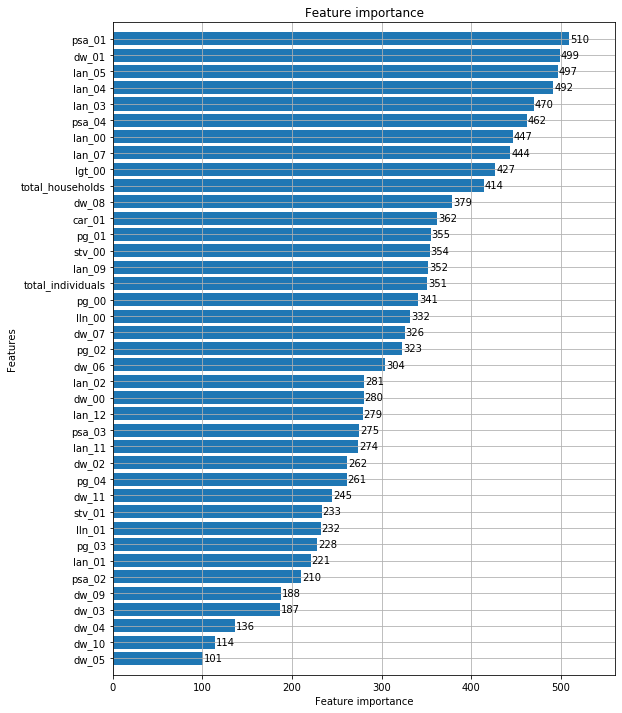

In [20]:
lgbm.plot_importance(lgb_model, height=0.8, figsize=(9,12))

In [26]:
xgb_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.05, n_jobs=-1)
xgb_model.fit(X, y)

[22:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [25]:
val_pred = xgb_model.predict(X_val)
error = rmse(y_val, val_pred)
error

6.573339734032822

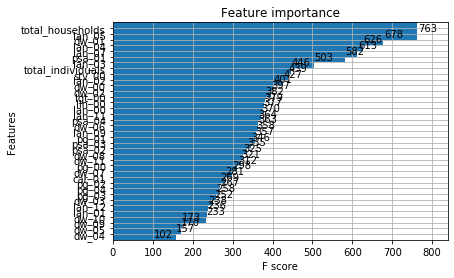

In [27]:
xgb.plot_importance(xgb_model, height=4.0)

In [291]:
# Feature selection
thresholds = np.sort(xgb_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    s_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.05, n_jobs=-1)
    s_model.fit(select_X_train, y_train)
    # eval model
    select_X_val = selection.transform(X_val)
    y_pred = s_model.predict(select_X_val)
    val_preds = [round(value) for value in y_pred]
    mse = rmse(y_val, val_preds)
    print("Thresh=%.3f, n=%d, mse: %.2f%" % (thresh, select_X_train.shape[1], mse))

[17:23:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in

In [226]:
# Random-Forest with CV
kf = KFold(n_splits=5, shuffle=False)

scores = []
for train, val in kf.split(X):
  model = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1,
                                random_state=42)
  model.fit(X.iloc[train], y.iloc[train])
  root_mse = rmse(y.iloc[val], model.predict(X.iloc[val]))
  scores.append(root_mse)
  print(root_mse)

print("Average score in 5-fold CV:", np.mean(scores))

6.494750601473455
6.851660681609302
6.091816041549932
6.212875813774724
5.82707948547263
Average score in 5-fold CV: 6.295636524776009


In [28]:
predictions = xgb_model.predict(test)
#preds = lgb_model.predict(test)

In [29]:
sub['ward'] = ids
sub['target_pct_vunerable'] = predictions
sub.head()

,ward,target_pct_vunerable
0,00A93O0,16.194267
1,01V40KO,39.696205
2,01ZHVW0,2.117779
3,028YQJX,3.041973
4,02G8W11,-0.089818


In [31]:
#%mkdir submissions
#sub.to_csv(f'./submissions/sub{np.round(np.mean(scores), 4)}.csv', index=False)
#sub.to_csv('./submissions/lgbm_sub.csv', index=False)
sub.to_csv('./submissions/xgb_sub.csv', index=False)